In [3]:
import os
import math
import wandb
import fnmatch
import warnings
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm.notebook import tqdm, trange
from matplotlib.backends.backend_agg import FigureCanvas

In [4]:
# jupylet pyglet
import trimesh
#trimesh.viewer.notebook.in_notebook()

In [5]:
# Render offscreen -- make sure to set the PyOpenGL platform
os.environ["PYOPENGL_PLATFORM"] = "egl"

In [22]:
os.environ["PYOPENGL_PLATFORM"] = "osmesa"

face_normals all zero, ignoring!


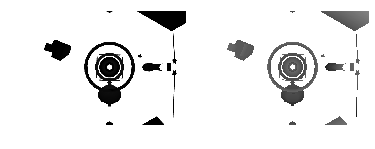

In [12]:
import pyrender
import trimesh
# Load the mesh and put it in a scene
fuze_trimesh = trimesh.load('satellite_models/Juno.stl')

#fuze_trimesh = trimesh.load('pyrender/examples/models/fuze.obj')
mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
scene = pyrender.Scene()
scene.add(mesh)

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 2.0)
#s = np.sqrt(2)/2

camera_pose = np.array([
       [1.0, 0.0, 0.0, 0.0],
       [0.0, 1.0, 0.0, 0.0],
       [0.0, 0.0, 1.0, -1.0],
       [0.0, 0.0, 0.0, 1.0],
    ])

scene.add(camera, pose=camera_pose)

# Set up the light -- a single spot light in the same spot as the camera
light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,innerConeAngle=np.pi/16.0)
scene.add(light, pose=camera_pose)


# Render the scene
r = pyrender.OffscreenRenderer(640, 480)
color, depth = r.render(scene)

# Show the images
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

In [9]:
color.shape

(480, 640, 3)

In [41]:
?fuze_trimesh.scene

Signature: fuze_trimesh.scene(**kwargs)
Docstring:
Returns a Scene object containing the current mesh.

Returns
---------
scene : trimesh.scene.scene.Scene
  Contains just the current mesh
File:      ~/.local/lib/python3.5/site-packages/trimesh/base.py
Type:      method


In [10]:
fuze_trimesh.apply_transform(trimesh.transformations.random_rotation_matrix())
fuze_trimesh.show()

In [13]:
wandb.login(key="1d2a8e338a0ecba6e71df00638afa00b6296a83e")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [14]:
wandb.init(project="testgcpvm") # DO NOT CHANGE THE PROJECT 

W&B Run: https://app.wandb.ai/rosenblatt/testgcpvm/runs/33o3b2qw

In [3]:
def stl2np_v1(your_mesh, rotation=(0,0,0), translation=(0,0), 
           elevation=0.0, azimuth=0.0, dimension=None, display=False,
           fieldOfView=0.05):
    
    """
    stl2np_v1 (numpy-stl package)

    Converts STL files to mesh objects and generates a black and white image of 
    the object in any given orientation. The return type is numpy.ndarray.

    inputFile       str        path to the stl file
    rotation        tuple      (x,y,z) rotation of STL object 90 degree scale
    translation     tuple      (x,y) translation of object w.r.t. the image
    dimension       int        sets square pixel dimensions of the generated PNG
    display         bool       option to display the figure
    fieldOfView     float      sets the 'distance' from the object
    
    NOTE: can we make fieldOfView a function of distance?
    
    """
    
    #####################################
    # CHANGE DIMENSION ARG TO TUPLE     #
    #####################################
    """
    
    Allow for the uses to specify seperate dimensions for x and y axis
    
    """
    """
    # Error handling
    if not os.path.isfile(inputFile):
        raise ValueError("inputFile not accessible")
    elif not inputFile.endswith('.stl'):
        raise ValueError("inputFile must be a .stl")
    elif not (type(rotation) in [tuple, list, set]):
        raise ValueError("invalid datatype for rotation argument")
    elif any(x >= 4 for x in rotation):
        warnings.warn("\nrotation argument has an axis greater than or equal to 360 degrees," +
                      " please use values between 0 and 4", SyntaxWarning)
    elif not (type(translation) in [tuple, list, set]):
        raise ValueError("invalid datatype for translation argument")
    elif type(dimension) != int:
        raise ValueError("invalid datatype for dimension argument")
    elif fieldOfView > 1:
        raise ValueError("fieldOfView value must be between 0 and 1")
    """
    #####################################
    # ADD ERROR HANDLING                #
    #####################################
    """
    
    1. Elevation constraints
    2. Azimuth constraints
    
    """

    # Create a new plot
    figure = plt.figure()
    axes = mplot3d.Axes3D(figure)

    # Force canvas (neccessary for numpy conversion)
    canvas = FigureCanvas(figure)
    
    # Load the STL files
    # MOVE OUT

    # Rotate
    your_mesh.rotate(rotation, math.radians(90))

    # Add the vectors to the plot
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

    # Auto scale to the mesh size
    scale = your_mesh.points.flatten('F')
    axes.auto_scale_xyz(scale, scale, scale)

    # Set elevation and azimuth
    axes.elev = elevation
    axes.azim = azimuth
    
    # Set field of view
    axes.margins(fieldOfView)

    # Remove axis
    axes.set_axis_off()
    
    # Convert figure to numpy matrix
    figure.canvas.draw()
    img = np.array(figure.canvas.renderer._renderer)
    
    # Convert image to black and white and invert coloring
    img = 0.2989*img[:,:,1] + 0.5870*img[:,:,2] + 0.1140*img[:,:,3]
    img = img.astype('uint8')
    img = np.abs(img - 254)
    
    # Crop to object
    obj_idx = np.nonzero(img)
    min_row = np.min(obj_idx[0])
    max_row = np.max(obj_idx[0])
    min_col = np.min(obj_idx[1])
    max_col = np.max(obj_idx[1])
    obj = img[min_row:max_row, min_col:max_col]
    
    # Calculate crop dimensions
    x = max_col - min_col
    y = max_row - min_row

    # Add zero padding to image and resize
    if dimension:
        if dimension > x and dimension > y:
            if y != x and x % dimension and y % dimension:            
                curr_scale = max(x / dimension, y / dimension)
                target_scale = math.ceil(curr_scale) * dimension
                top = (target_scale - y) // 2
                bot = target_scale - top - y
                left = (target_scale - x) // 2
                right = target_scale - left - x
                img = np.pad(obj, ((top, bot),(left, right)))
        else:
            #####################################
            # NEED TO SCALE IMAGE DOWN          #
            #####################################
            """
            
            1. Scale down while maintaining resolution
            2. Add padding
            3. Remove pass
            """
            pass
            

    #####################################
    # NEED TO TRANSLATE IMAGE           #
    #####################################
    """
    
    NOTE: for efficiency, this may need to be done during dimension reduction
    
    1. Verify translation is within image borders
    2. Translate object to position
    3. Remove translation warning
    
    """
    warnings.warn("translation is not currently supported", UserWarning)
    
    
    # Execute display option
    if display:
        plt.clf()
        plt.title('')
        plt.imshow(img, cmap='gray')
        plt.show()
    
    # Clear the figure from memory
    plt.close('all')
    
    # Clear all memory except img
    # garbage collect all except img
    
    return img

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:145: UserWarning: translation is not currently supported


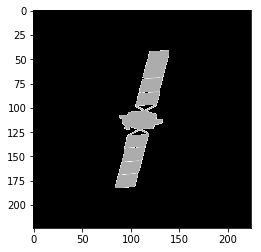

In [4]:
your_mesh = mesh.Mesh.from_file('satellite_models/Deep.stl')
out = stl2np_v1(your_mesh, dimension=224, rotation=(2,3,1), display=True)

In [3]:
def blurImg(img):
    #####################################
    # NEED TO BLUR IMAGE                #
    #####################################
    
    
    return

In [8]:
def generateH5Dataset(path, samples=1000, stdev=None, cache=False, method=''):
    """
    generateDataset
    
    Generates an HDF5 dataset of the values returned by the stl2np function
    
    #####################################
    # ADD MORE DESCRIPTION              #
    #####################################
    
    method = 'default', 'spark', 'multiprocessing'
    
    """

    files = os.listdir(path)
    pattern = "*.stl"
    stl_files = [os.path.join(path, entry) for entry in files if fnmatch.fnmatch(entry, pattern)]
    
    if method == 'multiprocessing':
        
        #####################################
        # INCOMPLETE                        #
        #####################################
        pass
    
        num_cores = multiprocessing.cpu_count()
        inputs = tqdm(range(stl_files))
        processed_list = Parallel(n_jobs=num_cores)(
            delayed(stl2np)(file, rotation=(0,0,0), dimension=224, fieldOfView=0.05) 
            for file in inputs)
        
    elif method == 'spark':
    
        #####################################
        # INCOMPLETE                        #
        #####################################
        pass
    
    else:
        
        # still fails around the same point
        def generate(files, iterations):
            for file in tqdm(files):
                # get mesh
                your_mesh = mesh.Mesh.from_file(file)
                for i in trange(iterations):
                    wandb.log({'iteration': i})
                    yield stl2np_v1(your_mesh, rotation=(0,0,0), dimension=224, fieldOfView=0.05)

        x = np.sum(generate(stl_files, 1000))
                
    return x

In [ ]:
out = generateH5Dataset('satellite_models')
#plt.imshow(out, cmap='grey')
#plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:145: UserWarning: translation is not currently supported
